
# Hawk data starboard wing data API

The aim of this notebook is to guide the user through the use of the API package `hawk` for interacting with the dataseries collected as part of the DTHIVE project at the [LVV](https://lvv.ac.uk/) in Sheffield in 2022. In order to use this notebook, the hawk package is required. The package is freely available and can be installed with pip (requres python 3.9+):

`pip install git+https://github.com/MDCHAMP/hawk-data`

This notebook will guide the user through the use of the `hawk` package for interacting with data collected as part of the DTHIVE project. For the experimental report and relevent publications please see the [data repository](https://figshare.com/s/88e34cc543ff5aeeb9f4). 

![The hawk aircraft att the LVV in SHeffield.](figures\Hawk_clean.jpg)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook")
sns.set_style("ticks")
sns.set_palette("Set2")

from hawk import SBW

## Basic usage

The `hawk` package contains the `hawk.SBW` function for interacting with the data from the starboard wing test. During testing, data were collected in both the time and frequency domains as part of two test campaigns named after the measurement equipment. These are:

- `LMS` (Frequency domain data)
- `NI` (Time domain data)

The `hawk.SBW` function provides a convenient wrapper for both of these test campaigns. To start exploring the data, simply call the function with a single argument of the path in which the data should be saved on disk.

It is the intention of the authors that the hawk data should be entirely self-describing. In order to facilitate this, the hawk package implements two functions `describe` and `explore`. Let us see the effect of these functions now.

In [3]:
data_dir = "./hawk_data"
data = SBW(data_dir)
data.describe()

'Header file for Hawk SBW dataset. DOI 10.15131/shef.data.22710040. See documentation for details.'

During the test campaigns a great deal of data were collected. Within the `data` object we created above, the various test series and signals are organised like a file-tree structure. The `describe` method above returns information pertaining to where in the tree we are currently. The `explore` method provides a look at what is contained within the tree beneath us. Lets see the result of calling the `explore` method on `data` (the top of the tree).

In [4]:
data.explore(2)

{'/': {'LMS': {'LMS/BR_AR': '...',
   'LMS/DS_CTE': '...',
   'LMS/DS_RLE': '...',
   'LMS/DS_TLE': '...',
   'LMS/FLS_AR': '...',
   'LMS/FSS_AR': '...',
   'LMS/RLS_AR': '...',
   'LMS/RSS_AR': '...',
   'LMS/xData': '...'},
  'NI': {'NI/ORP_VS': '...', 'NI/RPH_AR': '...', 'NI/xData': '...'}}}

As expected, this producdes a structured description of which test series are available. The only argument controls the depth through the tree that the `explore` function will search. 

Lets now try to access a test series that may or may not be downloaded in `data_dir` form the LMS campaign.

In [5]:
series = 'BR_AR' # i.e Burst-random amplitude-ramp 
rep = '01'
test_series = data["LMS"][series][rep]
test_series.explore(1)

{'LMS/BR_AR/01': {'LMS/BR_AR/01/EXH': '...',
  'LMS/BR_AR/01/FRC': '...',
  'LMS/BR_AR/01/LLC-01': '...',
  'LMS/BR_AR/01/LLC-02': '...',
  'LMS/BR_AR/01/LLC-03': '...',
  'LMS/BR_AR/01/LLC-04': '...',
  'LMS/BR_AR/01/LLC-05': '...',
  'LMS/BR_AR/01/LLC-06': '...',
  'LMS/BR_AR/01/LLC-07': '...',
  'LMS/BR_AR/01/LLG-01': '...',
  'LMS/BR_AR/01/LLG-02': '...',
  'LMS/BR_AR/01/LLG-03': '...',
  'LMS/BR_AR/01/LLG-04': '...',
  'LMS/BR_AR/01/LLG-05': '...',
  'LMS/BR_AR/01/LLG-06': '...',
  'LMS/BR_AR/01/LRT-01': '...',
  'LMS/BR_AR/01/LRT-02': '...',
  'LMS/BR_AR/01/LRT-03': '...',
  'LMS/BR_AR/01/LRT-04': '...',
  'LMS/BR_AR/01/LTC-01': '...',
  'LMS/BR_AR/01/LTC-02': '...',
  'LMS/BR_AR/01/LTC-03': '...',
  'LMS/BR_AR/01/LTC-04': '...',
  'LMS/BR_AR/01/LTC-05': '...',
  'LMS/BR_AR/01/LTC-06': '...',
  'LMS/BR_AR/01/LTC-07': '...',
  'LMS/BR_AR/01/TRI-X': '...',
  'LMS/BR_AR/01/TRI-Y': '...',
  'LMS/BR_AR/01/TRI-Z': '...',
  'LMS/BR_AR/01/ULC-01': '...',
  'LMS/BR_AR/01/ULC-02': '...',
 

Just by accessing the data in our code, the relevant files have been downloded and saved to disk in `data_dir`. If we were to access the data again, the downloaded data wold be used automatically. 

Looking at the output of the `explore` function, we can see that there are a number of sensor addresses, lets now take a look at the output of the `describe` function:

In [6]:
test_series.describe()

{'testCampaign': 'LMS',
 'testSeries': 'BR_AR',
 'testRepeat': '01',
 'acquisitionSampleRate': 'N/a',
 'addedMassg': 0.0,
 'ampLevelPercent': '50',
 'burstTimePercent': '90',
 'controlIteration': 'N/a',
 'controlLoop': 'Open',
 'date': '14/01/2022 10:32:33',
 'excitationLevelV': 0.4,
 'excitationType': 'Burst Random',
 'notes': '',
 'operator': 'MHA',
 'randomSeed': 'N/a',
 'recordingBandwith': '256',
 'repetitions': 10,
 'spectralLines': '8192'}

This is simply a python `dict` with all the details of the test setup, senor metadata and notes from the operators -- handy!

Lets look now at one of the sensors. Sensors are accesed by their key, sensor positions are shown below.

![Sensor layout](figures\wing_sens_layout.png)

In [7]:
sensor = "LLC-07"  # Lower leading edge central position 07 (wing tip)
sensor_data = test_series[sensor]
sensor_data.explore(1)

{'LMS/BR_AR/01/LLC-07': {'LMS/BR_AR/01/LLC-07/coherenceSpectrum': 'Dataset: Coherence Spectrum (/) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/frequencyResponseFunction': 'Dataset: Frequency Response Function (g/N) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/frf': 'Dataset: Frequency Response Function (g/N) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/spectra': 'Dataset: Spectra (g) (8193, 10)'}}

For the LMS campaign, there are three data channels (`frf` is simply shorthand for `frequencyResponseFunction`). For the NI data there is only one (`acceleration`).

Lets (finally) plot the data:

(8193, 10)


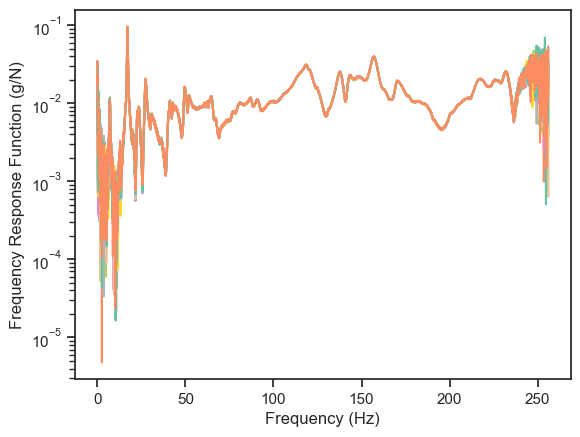

{'LMS/BR_AR/01/LLC-07': {'LMS/BR_AR/01/LLC-07/coherenceSpectrum': 'Dataset: Coherence Spectrum (/) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/frequencyResponseFunction': 'Dataset: Frequency Response Function (g/N) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/frf': 'Dataset: Frequency Response Function (g/N) (8193, 10)',
  'LMS/BR_AR/01/LLC-07/spectra': 'Dataset: Spectra (g) (8193, 10)'}}

In [15]:
signal = "frequencyResponseFunction"
frfs = sensor_data[signal]
print(frfs.shape) # (spectralLines, Nrepeats)

# Grab the frequency information from the xData group
fs = data['LMS/xData/freq'] 

plt.figure()
plt.semilogy(fs[:], np.abs(frfs[:]))
# note that the units can be pulled directly from the data
plt.xlabel(f"{fs.attrs['measurement']} ({fs.attrs['units']})") 
plt.ylabel(f"{frfs.attrs['measurement']} ({frfs.attrs['units']})")
plt.show()
sensor_data.explore()

Note that the metadata corresponding to the signals we are plotting is available in the `attrs` attribute of the dataset - how convenient!

So far we have taken a roundabout may of accessing the FRFs. Instead, we could have just used the path to the data we were interested in:

In [9]:
# note that we can access data directly from its path
frfs = data['/LMS/BR_AR/01/LLC-01/frf']
# or even
frfs = data[f'/LMS/{series}/{rep}/{sensor}/{signal}']
frfs.describe()

{'testCampaign': 'LMS',
 'testSeries': 'BR_AR',
 'testRepeat': '01',
 'sensorID': 'LLC-07',
 'singalType': 'frequencyResponseFunction',
 'measurement': 'Frequency Response Function',
 'units': 'g/N',
 'X': 3855,
 'Y': 485,
 'Z': -90,
 'assettNumber': 189,
 'gain': 10.69,
 'gainDate': '',
 'gainUnits': 'mV/g',
 'locationUnits': 'mm',
 'manufacturer': 'PCB Piezotronics',
 'model': 'M353B18',
 'acquisitionSampleRate': 'N/a',
 'addedMassg': 0.0,
 'ampLevelPercent': '50',
 'burstTimePercent': '90',
 'controlIteration': 'N/a',
 'controlLoop': 'Open',
 'date': '14/01/2022 10:32:33',
 'excitationLevelV': 0.4,
 'excitationType': 'Burst Random',
 'notes': '',
 'operator': 'MHA',
 'randomSeed': 'N/a',
 'recordingBandwith': '256',
 'repetitions': 10,
 'spectralLines': '8192'}

Note the general form of the path:

`/{campaign}/{series}/{rep}/{sensor}/{signal}`

For more information on the possible values of these fields please see the data report available [here](https://figshare.com/s/88e34cc543ff5aeeb9f4).. 

Lets now take a look at some of the time series data:

(32766, 10)


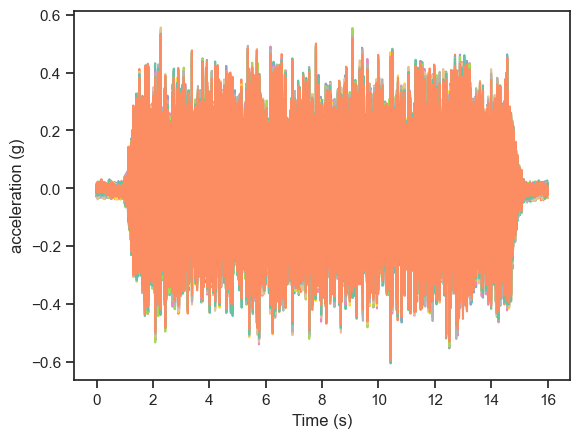

{'testCampaign': 'NI',
 'testSeries': 'RPH_AR',
 'testRepeat': '01',
 'sensorID': 'LLC-07',
 'singalType': 'acc',
 'measurement': 'acceleration',
 'sampleRate': 2048.0,
 'startTime': '2022-06-22T10:47:08.847278',
 'units': 'g',
 'X': 3855,
 'Y': 485,
 'Z': -90,
 'assettNumber': 189,
 'gain': 10.69,
 'gainDate': '',
 'gainUnits': 'mV/g',
 'locationUnits': 'mm',
 'manufacturer': 'PCB Piezotronics',
 'model': 'M353B18',
 'ExcitationSpectralLines': '16384',
 'acquisitionSampleRate': '2048',
 'addedMass': '0',
 'ampLevelPercent': '50',
 'burstTimePercent': '90',
 'controlIteration': '3',
 'controlLoop': 'Closed Loop',
 'date': '22/06/2022 11:54:27',
 'excitationType': 'Random Phase Multisine',
 'notes': 'Accidentally bumped plane on repetition 2 (minor bump starboard cockpit).',
 'operator': 'MDC',
 'randomSeed': '122125',
 'referenceAmplitudeValuesV': '1e-15, 0.4, 0.4, 1e-15',
 'referenceFrequencyValuesHz': '5, 50, 200, 256',
 'repetitions': 10}

In [10]:
ts = data['NI/xData/time']
accs = data['NI/RPH_AR/01/LLC-07/acc']
print(accs.shape) # (timePoints, Nrepeats)

plt.figure()
plt.plot(ts[:], accs[:])
plt.xlabel(f"{ts.attrs['measurement']} ({ts.attrs['units']})") 
plt.ylabel(f"{accs.attrs['measurement']} ({accs.attrs['units']})")
plt.show()

# Can access a full description of the test setup
accs.describe()

In just a few lines of python code we have downloaded and plotted the dat alongside all of the relevant metadata. 

## Advanced/production usage

So far we have seen how to access and explore the data. Lets now cover some more realistic usage scenarios.

Under the hood, all the data that is downloaded is in `.hdf5` format. This means that instead of using the `hawk` package you could instead use any off the shelf `.hdf5` viewing software. In fact, the `hawk` package is actually just a very simple wrapper for the `h5py` [docs here](https://docs.h5py.org/en/stable/). packcage that adds functionality for the `describe`, `explore` methods and manages automatic downloads -- neat!

Because the data is stored in `.hdf5` format, it is only read from disk when it is needed by the python program. This means that python keeps open (several) file objects while interacting with the data. To prevent corruption and other bugs, files in python should always be closed when they are not bieng used. Thankfully, the `SBW` function support python context managers. 

In [11]:
with SBW(data_dir) as data2:

    frfs = data2['/LMS/BR_AR/01/LLC-01/frf']
    frfs_numpy = np.array(data2['/LMS/BR_AR/01/LLC-01/frf'])

try:
    data2['/LMS/BR_AR/01/LLC-01/frf'].shape # This fails because the file is now closed
except ValueError:
    pass

frfs.shape # this is ok because the variable frfs is still referenced BUT internal references may be broken
frfs_numpy.shape # this will always be ok and should be considered best practice

(8193, 10)

Notice that once outside the context manager, the `data` object can no longer be interacted with. In the above, the variable `frf` maintains a link to the file object and so can still be accessed, however, internal links may be broken and so this behavouir should also be avoided.

You may have noticed in the plotting code above that the data were sliced into the `plot` function. This is because although the underlying `h5py.Dataset` implements some of the same functionality as `np.ndarray`, it cannot be considered a drop-in replacement.  

For best practice in production code, the required data should be cast to numpy arrays inside the context manager. There are several ways to achive this:

In [12]:
with SBW(data_dir) as data3:

    frf1 = data3['/LMS/BR_AR/01/LLC-01/frf']
    frf2 = np.array(data3['/LMS/BR_AR/01/LLC-01/frf']) # return np.ndarray
    frf3 = data3['/LMS/BR_AR/01/LLC-01/frf'][:] # also returns np.ndarray
    frf4 = data3['/LMS/BR_AR/01/LLC-01/frf'][:100] # also returns np.ndarray (simple sliceing only)

print(type(frf1))
print(type(frf2))
print(type(frf3))
print(type(frf4))


<class 'h5py._hl.dataset.Dataset'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Dataset structure

In order to avoid downloading all the data every time, the dataset has been divided into a number of independent files, each one correspondiong to one of the test series repeats. Overall there are 71 test series. 

The `hawk` package relies on a single 'header' `.hdf5` file for accessing all of the data simultaneously without loading it all in to memory (or even having all of the data on disk). This works thanks to the `ExternalLink` feature of the `.hdf5` spec, more details of which can be found [here](https://figshare.com/s/88e34cc543ff5aeeb9f4).